# Exercises

1. **Compute the euclidean distance for all passes and drives (successful ones) within the football pitch. Then, plot a histogram of the distributions:** (1 point)

    Euclidean distance is given by np.linalg.norm(p1-p2), where p1 & p2 are the origin and destination point in numpy array form (or define your own function)

    **Remember to unnormalize the positions before computing the distance!**

2. **Classify the passing actions in short, mid-range or long passes / drives. Find the number of short/mid-range/long passes and drives per game and the percentage over the total passes and drives.** (1 point)

3. **Build the following functions:** (5 point)

    - **To check whether a pass/drive from outside the box enters the box.**
      `box_points = [(0.84, 0.2), (1, 0.2), (1, 0.8), (0.84, 0.8)]`
    
    - **To check whether a pass/drive from inner positions goes to wide space (y < 0.2 or y > 0.8)**

    - **To check whether a pass/drive goes from inside the opponent convex hull to outside opponent convex hull AND VICE VERSA**

    - **To check whether a pass/drive goes from outside the half-spaces to inside half-spaces**

4. **Apply the previous functions into the dataframe. Keep the actions with origin and destination position in the second half of the pitch (x>0.5). Can you describe briefly the attacking playstyle of the team by using the percentages of the action's features previously computed?** (3 points)

5. **Use the _draw_field() function to plot the following features (choose only one match to plot):** (1 point)

    - **Passes finishing inside the defending area**
    - **Progressive drives in the last third of the pitch. They have to be at least 5 meter long drives!**
    - **Progressive passes into the half-spaces**
    - **It is mandatory to change the default colors by modifying the function parameters (see _draw_field() arguments). Choose the colors wisely, since data visualization has to make the information easy to read. BLACK AND WHITE ARE NOT ACCEPTED**


## Read Data

In this section, we will load the data and provide a detailed explanation of each feature available in the dataset.

- **match_id**: Unique identification code for each match. This should be read as a string to preserve any leading zeros or formatting.
- **event_type**: Describes the type of event in the match. Possible values include:
  - **Pass**: An intentional movement of the ball to another player.
  - **Drive**: A short movement of the ball without passing.
  - **Shot**: An attempt to score a goal.
- **team_name**: The name of the team performing the action. For simplicity, this dataset includes only one team, labeled as "Team 21".
- **start_frame** & **end_frame**: Indicate the starting and ending frames of the action within the match video. Since the video has a frame rate of 25 frames per second, you can calculate the total duration of each action using the formula:  
  \[
  \text{duration (in seconds)} = \frac{\text{end_frame} - \text{start_frame}}{25}
  \]
- **success**: Specifies whether the action was successful or not. Possible values are:
  - **Successful**
  - **Failed**
- **norm_origin_pos_x**, **norm_origin_pos_y**, **norm_destination_pos_x**, **norm_destination_pos_y**:  
  These features represent the normalized \(x\) and \(y\) coordinates of the action's starting and ending positions. The normalization ensures the values are within the range \([0, 1]\), regardless of the field's actual dimensions.

- **pos_players_tracking** & **opp_players_tracking**: Contain tracking data for all players involved in the match. These fields provide the positions of:
  - Players on the team in possession of the ball.
  - Opposing team players.  
  These values are stored as dictionaries, where keys represent player IDs and values contain position information. We will explore this structure in more detail later.

- **formation_line**: Indicates the line to which a player belongs in the formation. Values can be:
  - **0**: Strikers
  - **1**: Midfielders
  - **2**: Defenders  
  Note: These values are not sorted in the dataset.

- **which_line**: A sorted version of the `formation_line` feature. The mapping is as follows:
  - **0**: Strikers
  - **1**: Midfielders
  - **2**: Defenders


In [1]:
from google.colab import drive
drive.mount('/content/drive')

working_path = '/content/drive/MyDrive/Analysis/upc-geospatial/'
%cd '/content/drive/MyDrive/Analysis/upc-geospatial/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Analysis/upc-geospatial


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString, Point
from scipy.spatial import ConvexHull
from numpy import nan

pd.options.mode.chained_assignment = None

ww=105
hh=68

pitch_dim = np.array([ww,hh])



In [3]:
df = pd.read_csv(working_path+'lab_task.csv').drop('Unnamed: 0', axis=1)
df.head()

,match_id,event_type,team_name,start_frame,end_frame,success,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,pos_players_tracking,opp_players_tracking
0,5e307851c7946729bef63778,Pass,Team 21,12988,13005,Successful,0.480191,0.139984,0.480191,0.100046,"[{'norm_pos_y': 0.39588141176470587, 'speed_ms...","[{'norm_pos_y': 0.4970032941176471, 'speed_ms'..."
1,5e307851c7946729bef63778,Pass,Team 21,13005,13043,Successful,0.480191,0.100046,0.520163,0.220128,"[{'norm_pos_y': 0.3563470588235294, 'speed_ms'...","[{'norm_pos_y': 0.49727223529411757, 'speed_ms..."
2,5e307851c7946729bef63778,Pass,Team 21,13043,13075,Successful,0.520163,0.220128,0.490205,0.109997,"[{'norm_pos_y': 0.3281082352941176, 'speed_ms'...","[{'norm_pos_y': 0.4978101176470589, 'speed_ms'..."
3,5e307851c7946729bef63778,Drive,Team 21,13075,13100,Successful,0.493602,0.114569,0.497521,0.094264,"[{'norm_pos_y': 0.34209317647058823, 'speed_ms...","[{'norm_pos_y': 0.498348, 'speed_ms': 0.248407..."
4,5e307851c7946729bef63778,Drive,Team 21,13100,13125,Successful,0.497521,0.094264,0.501614,0.073555,"[{'norm_pos_y': 0.35392658823529416, 'speed_ms...","[{'norm_pos_y': 0.49875141176470594, 'speed_ms..."


## Visualization and Geometry Tools

This section provides a set of tools to manage and visualize data. The functions are grouped into the following categories:

- **Field Geometry**: Utilities to create a visual representation of the soccer field and manage coordinate transformations between normalized values and real-world dimensions.

- **Player Tracking and Formations**: Functions to extract and organize tracking data, allowing for the reconstruction of team formations and positioning on the field.

- **Action Visualization**: Tools to plot various elements of a match, including player positions, team formations, action trajectories (e.g., passes or drives), and spatial features like convex hulls.

- **Interactive Analysis**: Widgets to interactively explore and visualize data, enabling dynamic customization of the visual outputs.



In [4]:
def _point_to_meters_inverse(p, w=105, h=68):
    return np.array([p[0] * h, p[1] * w])

def _point_to_meters(p, w=105, h=68):
    return np.array([p[0] * w, p[1] * h])

def _draw_field(width=68, height=105, fig_size=8, lines_color="#bcbcbc", background_color="white"):
    ratio = width / float(height)
    f, ax = plt.subplots(1, 1, figsize=(fig_size * ratio, fig_size), dpi=100)
    if background_color:
        ax.add_patch(patches.Rectangle((0, 0), width, height, color=background_color))
    line_pts = [
        [_point_to_meters([0, 0]), _point_to_meters([0, 1])],
        [_point_to_meters([1, 0]), _point_to_meters([1, 1])],
        [_point_to_meters([0, 1]), _point_to_meters([1, 1])],
        [_point_to_meters([0, 0]), _point_to_meters([1, 0])],
    ]
    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], '-', alpha=0.8,
                lw=1.5, zorder=2, color=lines_color)
    line_pts = [
        [_point_to_meters([0.5, 0]), _point_to_meters([0.5, 1])],

        [[0, 24.85], [0, 2.85]],
        [[0, 13.85], [16.5, 13.85]],
        [[0, 54.15], [16.5, 54.15]],
        [[16.5, 13.85], [16.5, 54.15]],

        [[0, 24.85], [5.5, 24.85]],
        [[0, 43.15], [5.5, 43.15]],
        [[5.5, 24.85], [5.5, 43.15]],

        [[105, 24.85], [105, 2.85]],
        [[105, 13.85], [88.5, 13.85]],
        [[105, 54.15], [88.5, 54.15]],
        [[88.5, 13.85], [88.5, 54.15]],

        [[105, 24.85], [99.5, 24.85]],
        [[105, 43.15], [99.5, 43.15]],
        [[99.5, 24.85], [99.5, 43.14]]
    ]
    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], '-',
                alpha=0.8, lw=1.5, zorder=2, color=lines_color)
    # Circles
    ax.add_patch(patches.Wedge((94.0, 34.0), 9, 128, 232, fill=False, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))
    ax.add_patch(patches.Wedge((11.0, 34.0), 9, 308, 52, fill=False, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    ax.add_patch(patches.Wedge((52.5, 34), 9.5, 0, 360, fill=False, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))
    plt.axis('off')
    return f, ax

In [5]:
def get_players_positions(action_to_plot):
    pos_positions = []
    for player in eval(action_to_plot['pos_players_tracking']):
        position = np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim
        pos_positions.append(position)

    opp_positions = []
    for player in eval(action_to_plot['opp_players_tracking']):
        position = np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim
        opp_positions.append(position)

    pos_positions = np.array(pos_positions)
    opp_positions = np.array(opp_positions)

    return pos_positions, opp_positions

def build_formation_lines(players_tracking, is_own_team=True):
    line0, line1, line2 = [], [], []
    for player in players_tracking:
        if player['which_line'] == 0:
            line0.append(np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim)
        elif player['which_line'] == 1:
            line1.append(np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim)
        elif player['which_line'] == 2:
            line2.append(np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim)
        else:
            gk = np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim

    line0.sort(key=lambda x: x[1])
    line1.sort(key=lambda x: x[1])
    line2.sort(key=lambda x: x[1])

    line0 = LineString(line0) if len(line0) > 1 else Point(line0[0])
    line1 = LineString(line1) if len(line1) > 1 else Point(line1[0])
    line2 = LineString(line2) if len(line2) > 1 else Point(line2[0])
    gk = Point(gk)

    return line0, line1, line2, gk

def plot_players_positions(ax, pos_positions, opp_positions):
    ax.scatter(pos_positions[:, 0], pos_positions[:, 1], zorder=100, color='blue')
    ax.scatter(opp_positions[:, 0], opp_positions[:, 1], zorder=100, color='grey')

def plot_team_formation(ax, line0, line1, line2, gk, is_own_team=True):
    color = ['blue', 'red', 'orange'] if is_own_team else ['grey', 'grey', 'grey']

    for line, c in zip([line0, line1, line2], color):
        ax.plot(np.array(line.coords)[:, 0], np.array(line.coords)[:, 1], zorder=100, color=c)
        ax.scatter(np.array(line.coords)[:, 0], np.array(line.coords)[:, 1], zorder=100, color=c)

    ax.scatter(np.array(gk.coords)[:, 0], np.array(gk.coords)[:, 1], zorder=100, color='black')


def plot_action_line(ax, action_to_plot, color_condition):
    line = LineString([
        (np.array([action_to_plot['norm_origin_pos_x'], action_to_plot['norm_origin_pos_y']]) * pitch_dim),
        (np.array([action_to_plot['norm_destination_pos_x'], action_to_plot['norm_destination_pos_y']]) * pitch_dim)
    ])
    ax.plot(np.array(line.coords)[:, 0], np.array(line.coords)[:, 1], zorder=100, color=color_condition)
    ax.scatter(np.array(line.coords)[0][0], np.array(line.coords)[0][1], s=12, zorder=100, color=color_condition)
    ax.scatter(np.array(line.coords)[-1][0], np.array(line.coords)[-1][1], s=12, zorder=100, color=color_condition)

    ax.annotate('',
                xy=(np.array(line.coords)[-1][0], np.array(line.coords)[-1][1]),  # Destinazione
                xytext=(np.array(line.coords)[0][0], np.array(line.coords)[0][1]),  # Origine
                arrowprops=dict(facecolor=color_condition, edgecolor=color_condition, arrowstyle='->', lw=2, shrinkA=0))


def plot_convex_hull(ax, opp_positions):
    hull = ConvexHull(opp_positions)
    ax.fill(opp_positions[hull.vertices, 0], opp_positions[hull.vertices, 1], 'grey', alpha=0.2)

def plot_event_points(ax, yellow_point, violet_point):
    ax.scatter(yellow_point[0], yellow_point[1], color='yellow', zorder=100)
    ax.scatter(violet_point[0], violet_point[1], color='violet', zorder=100)

def plot_action(df, row_index, show_players=True, show_formation=True, show_action=True, show_convex_hull=True, show_points=True):
    fig, ax = _draw_field(fig_size=8, width=ww, height=hh, lines_color='black')

    action_to_plot = df.loc[row_index]

    pos_positions, opp_positions = get_players_positions(action_to_plot)

    pos_line0, pos_line1, pos_line2, pos_gk = build_formation_lines(eval(action_to_plot['pos_players_tracking']))
    opp_line0, opp_line1, opp_line2, opp_gk = build_formation_lines(eval(action_to_plot['opp_players_tracking']), is_own_team=False)

    if show_players:
        plot_players_positions(ax, pos_positions, opp_positions)

    if show_formation:
        plot_team_formation(ax, pos_line0, pos_line1, pos_line2, pos_gk, is_own_team=True)
        plot_team_formation(ax, opp_line0, opp_line1, opp_line2, opp_gk, is_own_team=False)

    color_condition = 'green' if action_to_plot['event_type'] == 'Pass' else 'violet'

    if show_action:
        plot_action_line(ax, action_to_plot, color_condition)

    if show_convex_hull:
        plot_convex_hull(ax, opp_positions)

    plt.show()

import ipywidgets as widgets
from ipywidgets import interact

def interactive_plot(df):
    global action_input
    action_input = widgets.IntText(value=80, description="Enter Index:")

    interact(plot_action,
             df=widgets.fixed(df),
             row_index=action_input,
             show_players=widgets.Checkbox(value=True, description="Show Players"),
             show_formation=widgets.Checkbox(value=True, description="Show Formation"),
             show_action=widgets.Checkbox(value=True, description="Show Action"),
             show_convex_hull=widgets.Checkbox(value=True, description="Show Convex Hull"),
             show_points=widgets.Checkbox(value=True, description="Show Points"))


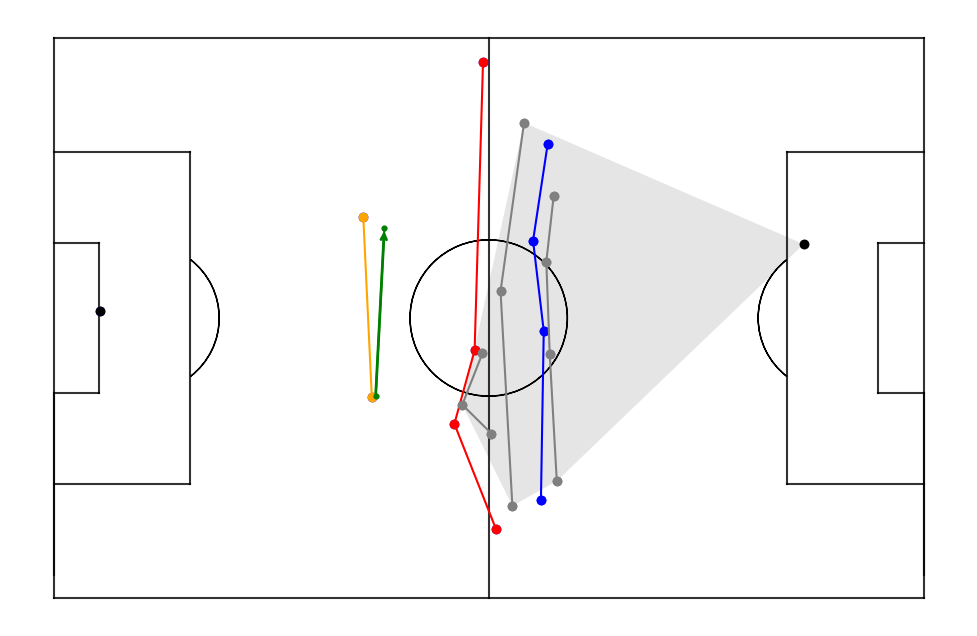

In [6]:
 plot_action(df, 60, show_players=True, show_formation=True, show_action=True, show_convex_hull=True)

In [7]:
interactive_plot(df)

interactive(children=(IntText(value=80, description='Enter Index:'), Checkbox(value=True, description='Show Pl…

## Exercise 1

Filtered the dataset to include only successful actions of type "Pass" and "Drive."
Calculated the Euclidean distance for these actions and stored it in a new column, `distance_m`.
The data was then split into two DataFrames, one for passes and one for drives.
Finally, two histograms were plotted to visualize the distance distributions separately for passes and drives.


In [8]:
df_successful = df[(df['event_type'].isin(['Pass', 'Drive']))&(df['success']=='Successful')].copy()

def euclidean_distance(origin, destination):
    return np.linalg.norm(origin-destination)

df_successful['distance_m'] = df_successful.apply(lambda row: euclidean_distance(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim
), axis=1)

drives_data = df_successful[df_successful['event_type'] == 'Drive'].copy()
passes_data = df_successful[df_successful['event_type'] == 'Pass'].copy()

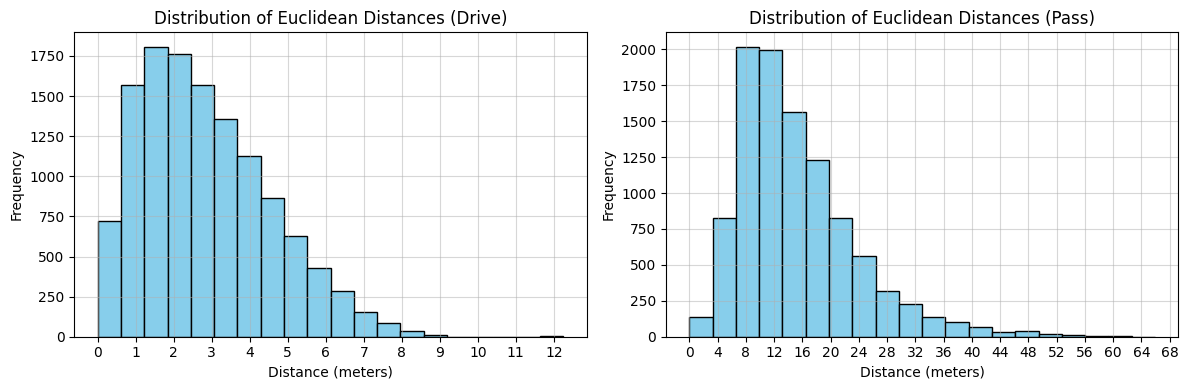

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(drives_data['distance_m'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Euclidean Distances (Drive)')
axes[0].set_xlabel('Distance (meters)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.5)
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1))

axes[1].hist(passes_data['distance_m'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Euclidean Distances (Pass)')
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.5)
axes[1].xaxis.set_major_locator(plt.MultipleLocator(4))

plt.tight_layout()
plt.show()


## Exercise 2

Classify the passing actions in short, mid-range, or long passes/drives. Find the number of short/mid-range/long passes and drives per game and the percentage over the total passes and drives.

In this case, I will use two approaches: technical and statistical.

- **Technical Approach - Passes**:
  Normally, passes are classified as follows:
  - Less than 15 meters: short
  - 15-30 meters: mid-range
  - More than 30 meters: long

  In a typical game, the distribution of passes by type is usually:
  - 45% - 50% short passes
  - 35% - 40% mid-range passes
  - The remaining percentage for long passes

- **Technical Approach - Drives**:
  For drives, the classification is typically:
  - Less than 3 meters: short
  - 3-6 meters: mid-range
  - More than 6 meters: long

- **Statistical Approach - Passes**:
  I used the calculation of the percentiles of the distribution of passing distances, typically found in a match:
  - P1 (45th percentile) = 13 meters
  - P2 (90th percentile) = 26 meters

- **Statistical Approach - Drives**:
  I used the calculation of the percentiles of the distribution of drive distances, typically found in a match:
  - P1 (45th percentile) = 2 meters
  - P2 (90th percentile) = 5 meters
  
    Given that the dataset contains very short drives, I decided to use the cutoff values derived from the percentiles, i.e., 2 meters for short drives and 5 meters for long drives.


### Passes Classification

In [10]:
passes_data['end_frame'] = np.where((passes_data['end_frame'] - passes_data['start_frame']) <= 0,
                                      passes_data['start_frame'] + 12,
                                      passes_data['end_frame'])

passes_data['time_frame'] = (passes_data['end_frame'] - passes_data['start_frame'])

passes_data['time_s'] = (passes_data['end_frame'] - passes_data['start_frame'])/25

passes_data['velocity_ms'] = passes_data['distance_m'] / passes_data['time_s']

passes_data.head()

,match_id,event_type,team_name,start_frame,end_frame,success,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,pos_players_tracking,opp_players_tracking,distance_m,time_frame,time_s,velocity_ms
0,5e307851c7946729bef63778,Pass,Team 21,12988,13005,Successful,0.480191,0.139984,0.480191,0.100046,"[{'norm_pos_y': 0.39588141176470587, 'speed_ms...","[{'norm_pos_y': 0.4970032941176471, 'speed_ms'...",2.715768,17,0.68,3.993776
1,5e307851c7946729bef63778,Pass,Team 21,13005,13043,Successful,0.480191,0.100046,0.520163,0.220128,"[{'norm_pos_y': 0.3563470588235294, 'speed_ms'...","[{'norm_pos_y': 0.49727223529411757, 'speed_ms...",9.181095,38,1.52,6.040194
2,5e307851c7946729bef63778,Pass,Team 21,13043,13075,Successful,0.520163,0.220128,0.490205,0.109997,"[{'norm_pos_y': 0.3281082352941176, 'speed_ms'...","[{'norm_pos_y': 0.4978101176470589, 'speed_ms'...",8.122719,32,1.28,6.345874
7,5e307851c7946729bef63778,Pass,Team 21,13328,13347,Successful,0.510148,0.040072,0.400159,0.109997,"[{'norm_pos_y': 0.4371638823529412, 'speed_ms'...","[{'norm_pos_y': 0.5022476470588235, 'speed_ms'...",12.489409,19,0.76,16.433432
9,5e307851c7946729bef63778,Pass,Team 21,13378,13408,Successful,0.390144,0.139984,0.280068,0.470109,"[{'norm_pos_y': 0.45424164705882353, 'speed_ms...","[{'norm_pos_y': 0.50292, 'speed_ms': 0.2393213...",25.249233,30,1.20,21.041028


In [11]:
def classify_pass(row):
    players_tracking = eval(row['pos_players_tracking'])
    origin_pos = np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim
    destination_pos = np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim

    origin_player = min(players_tracking, key=lambda player: np.linalg.norm(np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim - origin_pos))
    destination_player = min(players_tracking, key=lambda player: np.linalg.norm(np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim - destination_pos))

    origin_line = origin_player['which_line']
    destination_line = destination_player['which_line']

    if origin_line == 2:
        if destination_line == 2:
            return 'DD'
        elif destination_line == 1:
            return 'DM'
        elif destination_line == 0:
            return 'DS'
    elif origin_line == 1:
        if destination_line == 2:
            return 'MD'
        elif destination_line == 1:
            return 'MM'
        elif destination_line == 0:
            return 'MS'
    elif origin_line == 0:
        if destination_line == 2:
            return 'SD'
        elif destination_line == 1:
            return 'SM'
        elif destination_line == 0:
            return 'SS'


passes_data['passes_line_classification'] = passes_data.apply(lambda row: classify_pass(row), axis=1)

In [12]:
passes_data.head()

,match_id,event_type,team_name,start_frame,end_frame,success,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,pos_players_tracking,opp_players_tracking,distance_m,time_frame,time_s,velocity_ms,passes_line_classification
0,5e307851c7946729bef63778,Pass,Team 21,12988,13005,Successful,0.480191,0.139984,0.480191,0.100046,"[{'norm_pos_y': 0.39588141176470587, 'speed_ms...","[{'norm_pos_y': 0.4970032941176471, 'speed_ms'...",2.715768,17,0.68,3.993776,DD
1,5e307851c7946729bef63778,Pass,Team 21,13005,13043,Successful,0.480191,0.100046,0.520163,0.220128,"[{'norm_pos_y': 0.3563470588235294, 'speed_ms'...","[{'norm_pos_y': 0.49727223529411757, 'speed_ms...",9.181095,38,1.52,6.040194,MM
2,5e307851c7946729bef63778,Pass,Team 21,13043,13075,Successful,0.520163,0.220128,0.490205,0.109997,"[{'norm_pos_y': 0.3281082352941176, 'speed_ms'...","[{'norm_pos_y': 0.4978101176470589, 'speed_ms'...",8.122719,32,1.28,6.345874,MM
7,5e307851c7946729bef63778,Pass,Team 21,13328,13347,Successful,0.510148,0.040072,0.400159,0.109997,"[{'norm_pos_y': 0.4371638823529412, 'speed_ms'...","[{'norm_pos_y': 0.5022476470588235, 'speed_ms'...",12.489409,19,0.76,16.433432,MD
9,5e307851c7946729bef63778,Pass,Team 21,13378,13408,Successful,0.390144,0.139984,0.280068,0.470109,"[{'norm_pos_y': 0.45424164705882353, 'speed_ms...","[{'norm_pos_y': 0.50292, 'speed_ms': 0.2393213...",25.249233,30,1.20,21.041028,DD


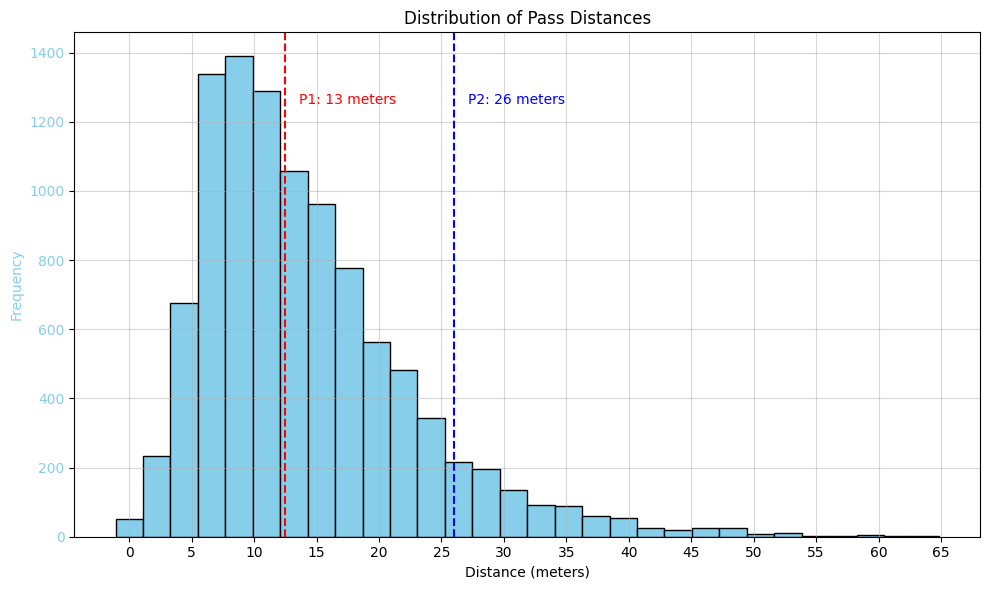

In [13]:

distances = passes_data['distance_m']
bins = np.linspace(distances.min(), distances.max(), 31)

freq, _ = np.histogram(distances, bins=bins)

p1 = np.percentile(distances, 45)
p2 = np.percentile(distances, 90)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(bins[:-1], freq, width=bins[1] - bins[0], color='skyblue', edgecolor='black')
ax1.set_xlabel('Distance (meters)')
ax1.set_ylabel('Frequency', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax1.axvline(x=p1, color='red', linestyle='--')
ax1.axvline(x=p2, color='blue', linestyle='--')

ax1.text(p1+5, max(freq) * 0.9, f'P1: {round(p1)} meters', color='red', ha='center')
ax1.text(p2+5, max(freq) * 0.9, f'P2: {round(p2)} meters', color='blue', ha='center')

ax1.xaxis.set_major_locator(plt.MultipleLocator(5))


plt.title('Distribution of Pass Distances')
ax1.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
conditions = [
    passes_data['distance_m'] <= p1,
    (passes_data['distance_m'] > p1) & (passes_data['distance_m'] <= p2),
    passes_data['distance_m'] > p2
]

choices = ['short', 'mid-range', 'long']

passes_data['passes_type'] = np.select(conditions, choices, default=np.nan)

print(passes_data['passes_type'].isna().sum())
passes_data['passes_type'].value_counts().reset_index()

0


,passes_type,count
0,short,4554
1,mid-range,4553
2,long,1012


In [15]:
total_passes = len(passes_data)
short_passes = len(passes_data[passes_data['passes_type'] == 'short'])
mid_passes = len(passes_data[passes_data['passes_type'] == 'mid-range'])
long_passes = len(passes_data[passes_data['passes_type'] == 'long'])

short_pct = short_passes / total_passes * 100
mid_pct = mid_passes / total_passes * 100
long_pct = long_passes / total_passes * 100

print(f"Short passes: {short_pct:.2f}%")
print(f"Mid-range passes: {mid_pct:.2f}%")
print(f"Long passes: {long_pct:.2f}%")

Short passes: 45.00%
Mid-range passes: 44.99%
Long passes: 10.00%


### Drives classification

In [16]:
drives_data.head()

,match_id,event_type,team_name,start_frame,end_frame,success,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,pos_players_tracking,opp_players_tracking,distance_m
3,5e307851c7946729bef63778,Drive,Team 21,13075,13100,Successful,0.493602,0.114569,0.497521,0.094264,"[{'norm_pos_y': 0.34209317647058823, 'speed_ms...","[{'norm_pos_y': 0.498348, 'speed_ms': 0.248407...",1.440753
4,5e307851c7946729bef63778,Drive,Team 21,13100,13125,Successful,0.497521,0.094264,0.501614,0.073555,"[{'norm_pos_y': 0.35392658823529416, 'speed_ms...","[{'norm_pos_y': 0.49875141176470594, 'speed_ms...",1.472298
5,5e307851c7946729bef63778,Drive,Team 21,13125,13150,Successful,0.501614,0.073555,0.505184,0.057284,"[{'norm_pos_y': 0.36562552941176474, 'speed_ms...","[{'norm_pos_y': 0.4990203529411764, 'speed_ms'...",1.168215
6,5e307851c7946729bef63778,Drive,Team 21,13150,13175,Successful,0.505184,0.057284,0.510148,0.051368,"[{'norm_pos_y': 0.3704664705882353, 'speed_ms'...","[{'norm_pos_y': 0.49942376470588234, 'speed_ms...",0.658431
8,5e307851c7946729bef63778,Drive,Team 21,13347,13372,Successful,0.397633,0.114434,0.392669,0.130436,"[{'norm_pos_y': 0.4405256470588235, 'speed_ms'...","[{'norm_pos_y': 0.5025165882352941, 'speed_ms'...",1.206523


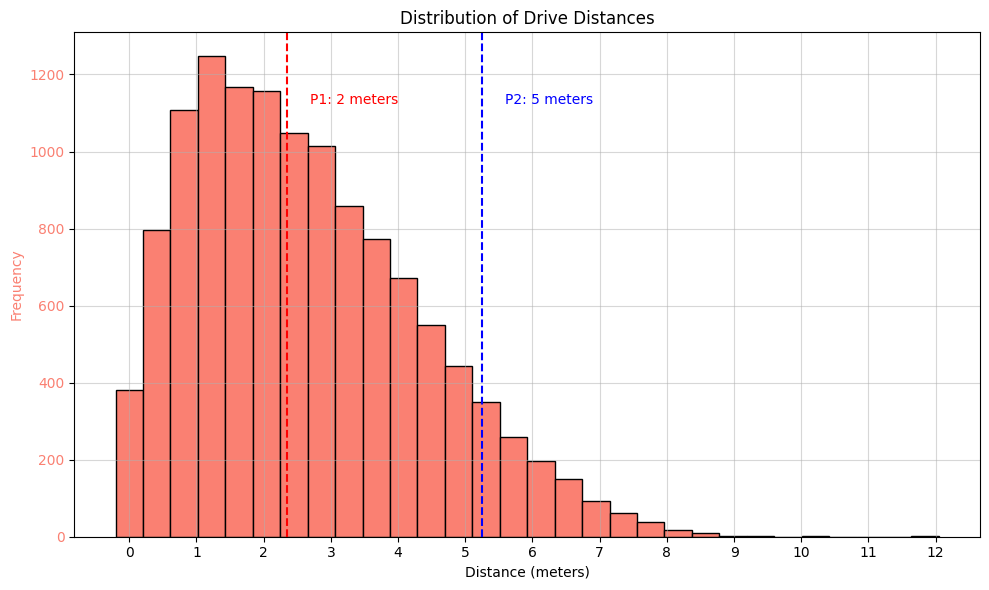

In [17]:
distances_drives = drives_data['distance_m']
bins_drives = np.linspace(distances_drives.min(), distances_drives.max(), 31)

freq_drives, _ = np.histogram(distances_drives, bins=bins_drives)

p1_drives = np.percentile(distances_drives, 45)
p2_drives = np.percentile(distances_drives, 90)

fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.bar(bins_drives[:-1], freq_drives, width=bins_drives[1] - bins_drives[0], color='salmon', edgecolor='black')
ax2.set_xlabel('Distance (meters)')
ax2.set_ylabel('Frequency', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

ax2.axvline(x=p1_drives, color='red', linestyle='--')
ax2.axvline(x=p2_drives, color='blue', linestyle='--')

ax2.text(p1_drives+1, max(freq_drives) * 0.9, f'P1: {round(p1_drives)} meters', color='red', ha='center')
ax2.text(p2_drives+1, max(freq_drives) * 0.9, f'P2: {round(p2_drives)} meters', color='blue', ha='center')

ax2.xaxis.set_major_locator(plt.MultipleLocator(1))

plt.title('Distribution of Drive Distances')
ax2.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


In [18]:
conditions = [
    drives_data['distance_m'] <= p1_drives,
    (drives_data['distance_m'] > p1_drives) & (drives_data['distance_m'] <= p2_drives),
    drives_data['distance_m'] > p2_drives
]

choices = ['short', 'mid-range', 'long']

drives_data['drives_type'] = np.select(conditions, choices, default=np.nan)

print(drives_data['drives_type'].isna().sum())
drives_data['drives_type'].value_counts().reset_index()


0


,drives_type,count
0,short,5581
1,mid-range,5580
2,long,1240


In [19]:

total_drives = len(drives_data)
short_drives = len(drives_data[drives_data['drives_type'] == 'short'])
mid_drives = len(drives_data[drives_data['drives_type'] == 'mid-range'])
long_drives = len(drives_data[drives_data['drives_type'] == 'long'])

short_pct_drives = short_drives / total_drives * 100
mid_pct_drives = mid_drives / total_drives * 100
long_pct_drives = long_drives / total_drives * 100

print(f"Short drives: {short_pct_drives:.2f}%")
print(f"Mid-range drives: {mid_pct_drives:.2f}%")
print(f"Long drives: {long_pct_drives:.2f}%")


Short drives: 45.00%
Mid-range drives: 45.00%
Long drives: 10.00%


## Exercise 3

For this exercise, I decided to create a **single generic function** that takes four arguments as input:

- **Origin**: The starting point of the action.
- **Destination**: The endpoint of the action.
- **Areas**: A list of generic areas or convex hulls to check.
- **entry_type** (optional, default="outside_to_inside"): The type of entry, such as "outside_to_inside."

The idea is to create one versatile function and apply it to all the cases required in this exercise. This way, the function can handle different scenarios while maintaining flexibility.

I then created the specific areas to pass as arguments to the function based on the areas required for each case.


In [20]:
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)


def check_area_entry(origin, destination, areas, entry_type="outside_to_inside"):
    origin_in_any_area = False
    destination_in_areas = 0

    for area_points in areas:
        hull = ConvexHull(area_points)
        if point_in_hull(origin, hull):
            origin_in_any_area = True
        if point_in_hull(destination, hull):
            destination_in_areas += 1

    if entry_type == "outside_to_inside":
        return not origin_in_any_area and destination_in_areas == 1
    elif entry_type == "inside_to_outside":
        return origin_in_any_area and destination_in_areas == 0
    else:
        raise ValueError("Invalid entry_type. Use 'outside_to_inside' or 'inside_to_outside'.")


def plot_areas_on_field(areas, fig_size, width, height, lines_color='black'):
    fig, ax = _draw_field(fig_size=fig_size, width=width, height=height, lines_color=lines_color)
    for area in areas:
        hull = ConvexHull(area)
        vertices = area[hull.vertices]
        polygon = plt.Polygon(vertices, closed=True, edgecolor='r', facecolor='r', alpha=0.5, zorder=10)
        ax.add_patch(polygon)
    plt.show()


def get_opp_position(row):
    opp_positions = []
    for player in eval(row['opp_players_tracking']):
        position = np.array([player['norm_pos_x'], player['norm_pos_y']]) * pitch_dim
        opp_positions.append(position)
    opp_positions = np.array(opp_positions)
    return opp_positions


**To check whether a pass/drive from outside the box enters the box**

I created and plotted the area representing the box. This area was passed as an argument to the generic function to check if a pass or drive starts from outside the box and enters it. This ensures that we can analyze the movement of passes or drives into the box from outside.


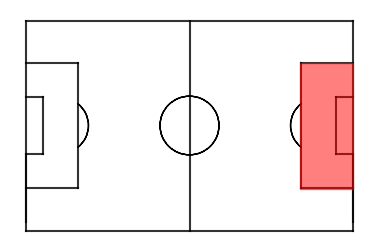

In [21]:
box_area = np.array([
    [0.84 * ww, 0.2 * hh],
    [1 * ww, 0.2 * hh],
    [1 * ww, 0.8 * hh],
    [0.84 * ww, 0.8 * hh]
])

plot_areas_on_field([box_area], fig_size=3, width=ww, height=hh)

**To check whether a pass/drive from inner positions goes to wide space (y < 0.2 or y > 0.8)**

I created and plotted the area representing the wide spaces, defined by the y-coordinate being less than 0.2 or greater than 0.8. This area was passed as an argument to the generic function to check whether a pass or drive originating from inner positions goes to the wide space, helping to analyze distribution towards the flanks.


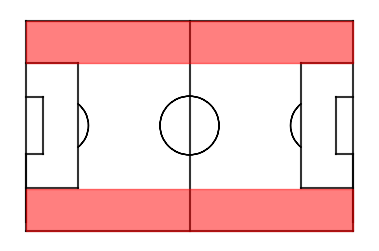

In [22]:
wide_areas_lower = np.array([
    [0, 0],
    [ww, 0],
    [ww, 0.2 * hh],
    [0, 0.2 * hh]
])

wide_areas_upper = np.array([
    [0, 0.8 * hh],
    [ww, 0.8 * hh],
    [ww, hh],
    [0, hh]
])

wide_areas = [wide_areas_lower, wide_areas_upper]

plot_areas_on_field(wide_areas, fig_size=3, width=ww, height=hh)

**To check whether a pass/drive goes from outside the half-spaces to inside half-spaces**

I created and plotted the area representing the half-spaces. This area was passed as an argument to the function to check whether a pass or drive starts from outside the half-spaces and moves inside them, allowing us to analyze the flow of play between the wider and more central areas of the pitch.


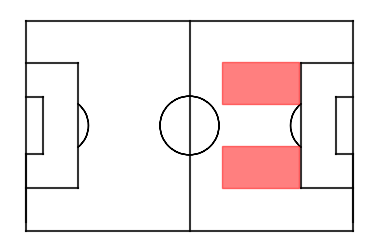

In [23]:
half_spaces1 = np.array([
    [0.6 * ww, 0.2005 * hh],
    [0.6 * ww + 0.235 * ww, 0.2005 * hh],
    [0.6 * ww + 0.235 * ww, 0.2005 * hh + 0.2005 * hh],
    [0.6 * ww, 0.2005 * hh + 0.2005 * hh]
])

half_spaces2 = np.array([
    [0.6 * ww, 0.8005 * hh],
    [0.6 * ww + 0.235 * ww, 0.8005 * hh],
    [0.6 * ww + 0.235 * ww, 0.8005 * hh + (0.8005 - 1) * hh],
    [0.6 * ww, 0.8005 * hh + (0.8005 - 1) * hh]
])

half_spaces = [half_spaces1, half_spaces2]

plot_areas_on_field(half_spaces, fig_size=3, width=ww, height=hh)

**To check whether a pass/drive goes from inside the opponent convex hull to outside the opponent convex hull AND VICE VERSA**

For this case, I will create the area representing the opponent’s convex hull and pass it to the function row by row. The goal is to check whether a pass or drive starts from inside the opponent's convex hull and exits, or vice versa, providing insights into how the ball moves relative to the opponent's defensive shape.


## Exercise 4

I apply the previously created functions to the dataframe. The functions are used to analyze various types of movements, such as:

- Checking whether a pass/drive from outside the box enters the box.
- Checking whether a pass/drive from inner positions goes to wide spaces.
- Checking whether a pass/drive moves between the half-spaces.
- Checking whether a pass/drive goes from inside the opponent’s convex hull to outside and vice versa.

These functions are applied to each row of the dataframe, allowing for a detailed analysis of the passes and drives and their relationships with different areas of the pitch. This step enables the classification of the events based on their spatial characteristics, providing valuable insights into the dynamics of the game.


In [24]:
df_successful['from_outside_to_box'] = df_successful.apply(lambda row: check_area_entry(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim,
    [box_area]
), axis=1)

df_successful['from_inner_to_wide'] = df_successful.apply(lambda row: check_area_entry(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim,
    wide_areas
), axis=1)


df_successful['from_outside_to_half_spaces'] = df_successful.apply(lambda row: check_area_entry(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim,
    half_spaces
), axis=1)

In [25]:

df_successful['from_outside_to_inside_convex_hull'] = df_successful.apply(lambda row: check_area_entry(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim,
    [get_opp_position(row)]
), axis=1)

df_successful['from_inside_to_outside_convex_hull'] = df_successful.apply(lambda row: check_area_entry(
    np.array([row['norm_origin_pos_x'], row['norm_origin_pos_y']]) * pitch_dim,
    np.array([row['norm_destination_pos_x'], row['norm_destination_pos_y']]) * pitch_dim,
     [get_opp_position(row)]
    , entry_type="inside_to_outside"
), axis=1)

In [26]:
df_successful.head()

,match_id,event_type,team_name,start_frame,end_frame,success,norm_origin_pos_x,norm_origin_pos_y,norm_destination_pos_x,norm_destination_pos_y,pos_players_tracking,opp_players_tracking,distance_m,from_outside_to_box,from_inner_to_wide,from_outside_to_half_spaces,from_outside_to_inside_convex_hull,from_inside_to_outside_convex_hull
0,5e307851c7946729bef63778,Pass,Team 21,12988,13005,Successful,0.480191,0.139984,0.480191,0.100046,"[{'norm_pos_y': 0.39588141176470587, 'speed_ms...","[{'norm_pos_y': 0.4970032941176471, 'speed_ms'...",2.715768,False,False,False,False,True
1,5e307851c7946729bef63778,Pass,Team 21,13005,13043,Successful,0.480191,0.100046,0.520163,0.220128,"[{'norm_pos_y': 0.3563470588235294, 'speed_ms'...","[{'norm_pos_y': 0.49727223529411757, 'speed_ms...",9.181095,False,False,False,True,False
2,5e307851c7946729bef63778,Pass,Team 21,13043,13075,Successful,0.520163,0.220128,0.490205,0.109997,"[{'norm_pos_y': 0.3281082352941176, 'speed_ms'...","[{'norm_pos_y': 0.4978101176470589, 'speed_ms'...",8.122719,False,True,False,False,True
3,5e307851c7946729bef63778,Drive,Team 21,13075,13100,Successful,0.493602,0.114569,0.497521,0.094264,"[{'norm_pos_y': 0.34209317647058823, 'speed_ms...","[{'norm_pos_y': 0.498348, 'speed_ms': 0.248407...",1.440753,False,False,False,False,False
4,5e307851c7946729bef63778,Drive,Team 21,13100,13125,Successful,0.497521,0.094264,0.501614,0.073555,"[{'norm_pos_y': 0.35392658823529416, 'speed_ms...","[{'norm_pos_y': 0.49875141176470594, 'speed_ms...",1.472298,False,False,False,False,False



I filter the dataset to keep only the actions where the origin and destination positions are in the second half of the pitch (x > 0.5).

Then, I calculate the percentages of each feature that I previously computed for both passes and drives.

The following percentages are calculated for the filtered dataset:

- **Passes:**
  - Percentage of passes from outside to inside convex hull
  - Percentage of passes from outside to box
  - Percentage of passes from inner to wide space
  - Percentage of passes from outside to half-spaces
  - Percentage of passes from inside to outside convex hull

- **Drives:**
  - Percentage of drives from outside to inside convex hull
  - Percentage of drives from outside to box
  - Percentage of drives from inner to wide space
  - Percentage of drives from outside to half-spaces
  - Percentage of drives from inside to outside convex hull


In [27]:
df_successful_2ndhalf = df_successful[
    (df_successful['norm_origin_pos_x'] > 0.5) &
    (df_successful['norm_destination_pos_x'] > 0.5)
]

In [28]:
total_actions = len(df_successful_2ndhalf)

pass_actions = df_successful_2ndhalf[df_successful_2ndhalf['event_type'] == 'Pass']
drive_actions = df_successful_2ndhalf[df_successful_2ndhalf['event_type'] == 'Drive']

total_passes = len(pass_actions)
total_drives = len(drive_actions)

outside_to_inside_convex_hull_pass_count = pass_actions['from_outside_to_inside_convex_hull'].sum()
outside_to_box_pass_count = pass_actions['from_outside_to_box'].sum()
inner_to_wide_pass_count = pass_actions['from_inner_to_wide'].sum()
outside_to_half_spaces_pass_count = pass_actions['from_outside_to_half_spaces'].sum()
inside_to_outside_convex_hull_pass_count = pass_actions['from_inside_to_outside_convex_hull'].sum()

outside_to_inside_convex_hull_drive_count = drive_actions['from_outside_to_inside_convex_hull'].sum()
outside_to_box_drive_count = drive_actions['from_outside_to_box'].sum()
inner_to_wide_drive_count = drive_actions['from_inner_to_wide'].sum()
outside_to_half_spaces_drive_count = drive_actions['from_outside_to_half_spaces'].sum()
inside_to_outside_convex_hull_drive_count = drive_actions['from_inside_to_outside_convex_hull'].sum()

outside_to_inside_convex_hull_pass_percentage = (outside_to_inside_convex_hull_pass_count / total_passes) * 100
outside_to_box_pass_percentage = (outside_to_box_pass_count / total_passes) * 100
inner_to_wide_pass_percentage = (inner_to_wide_pass_count / total_passes) * 100
outside_to_half_spaces_pass_percentage = (outside_to_half_spaces_pass_count / total_passes) * 100
inside_to_outside_convex_hull_pass_percentage = (inside_to_outside_convex_hull_pass_count / total_passes) * 100

outside_to_inside_convex_hull_drive_percentage = (outside_to_inside_convex_hull_drive_count / total_drives) * 100
outside_to_box_drive_percentage = (outside_to_box_drive_count / total_drives) * 100
inner_to_wide_drive_percentage = (inner_to_wide_drive_count / total_drives) * 100
outside_to_half_spaces_drive_percentage = (outside_to_half_spaces_drive_count / total_drives) * 100
inside_to_outside_convex_hull_drive_percentage = (inside_to_outside_convex_hull_drive_count / total_drives) * 100

print(f"Passes: ")
print(f"Percentage of passes from outside to inside convex hull: {outside_to_inside_convex_hull_pass_percentage:.2f}%")
print(f"Percentage of passes from outside to box: {outside_to_box_pass_percentage:.2f}%")
print(f"Percentage of passes from inner to wide: {inner_to_wide_pass_percentage:.2f}%")
print(f"Percentage of passes from outside to half spaces: {outside_to_half_spaces_pass_percentage:.2f}%")
print(f"Percentage of passes from inside to outside convex hull: {inside_to_outside_convex_hull_pass_percentage:.2f}%")

print(f"\nDrives: ")
print(f"Percentage of drives from outside to inside convex hull: {outside_to_inside_convex_hull_drive_percentage:.2f}%")
print(f"Percentage of drives from outside to box: {outside_to_box_drive_percentage:.2f}%")
print(f"Percentage of drives from inner to wide: {inner_to_wide_drive_percentage:.2f}%")
print(f"Percentage of drives from outside to half spaces: {outside_to_half_spaces_drive_percentage:.2f}%")
print(f"Percentage of drives from inside to outside convex hull: {inside_to_outside_convex_hull_drive_percentage:.2f}%")


Passes: 
Percentage of passes from outside to inside convex hull: 18.71%
Percentage of passes from outside to box: 4.14%
Percentage of passes from inner to wide: 19.35%
Percentage of passes from outside to half spaces: 17.52%
Percentage of passes from inside to outside convex hull: 18.06%

Drives: 
Percentage of drives from outside to inside convex hull: 5.52%
Percentage of drives from outside to box: 1.42%
Percentage of drives from inner to wide: 2.12%
Percentage of drives from outside to half spaces: 5.97%
Percentage of drives from inside to outside convex hull: 3.02%


**Attacking Playstyle Description**

Based on the computed percentages of action features, the attacking playstyle of the team can be summarized as follows:

- **Passes:**
  - **Nearly one out of every five passes (18.71%)** comes from outside to inside the convex hull, showing a tendency to progress centrally.
  - **Almost one in five passes (19.35%)** is played from inner positions to wide areas, highlighting an emphasis on wide play.
  - Around **18% of passes (18.06%)** move from inside to outside the convex hull, indicating a strong effort to spread the play across the field.
  - **One in every twenty-five passes (4.14%)** goes from outside to the box, reflecting occasional direct attempts toward the final third.

- **Drives:**
  - **One in twenty drives (5.52%)** comes from outside to inside the convex hull, showing some central dribbling progression.
  - **One in every seventeen drives (5.97%)** goes from outside into the half-spaces, which suggests some attempts to break into central attacking areas.
  - **Less than one in thirty drives (3.02%)** go from inside to outside the convex hull, indicating fewer attempts to push wide from central positions.


## Exercise 5

I used the `_draw_field()` function to visually represent specific features from one match. The goal was to plot the following features on the field, using distinct colors for each:

- **Passes finishing inside the defending area** (color: **blue**): These are passes that end in the opponent’s defending area, typically near the goal.
- **Progressive drives in the last third of the pitch (at least 5 meters long)** (color: **green**): These are drives that cover at least 5 meters, progressing through the final third of the field.
- **Progressive passes into the half-spaces** (color: **red**): These passes move into the half-spaces, the areas between the central and wide zones, contributing to creating attacking options.

By using these colors, I could clearly distinguish the different types of actions and better analyze the team’s attacking strategy in the game.


In [29]:
def filter_passes_to_defending_area(df, match_id):
    df_match = df[df['match_id'] == match_id]
    df_passes = df_match[df_match['event_type'] == 'Pass']
    df_passes_in_defending_area = df_passes[df_passes['from_outside_to_box'] == True]
    return df_passes_in_defending_area

def filter_progressive_drives(df, match_id, min_distance=5):
    df_match = df[df['match_id'] == match_id]
    df_drives = df_match[df_match['event_type'] == 'Drive']
    progressive_drives = df_drives[df_drives['norm_destination_pos_x'] > (1 - 1/3)]
    return progressive_drives[progressive_drives['distance_m'] >= min_distance]

def filter_progressive_passes_to_half_spaces(df, match_id):
    df_match = df[df['match_id'] == match_id]
    df_passes = df_match[df_match['event_type'] == 'Pass']
    progressive_passes = df_passes[df_passes['from_outside_to_half_spaces'] == True]
    return progressive_passes


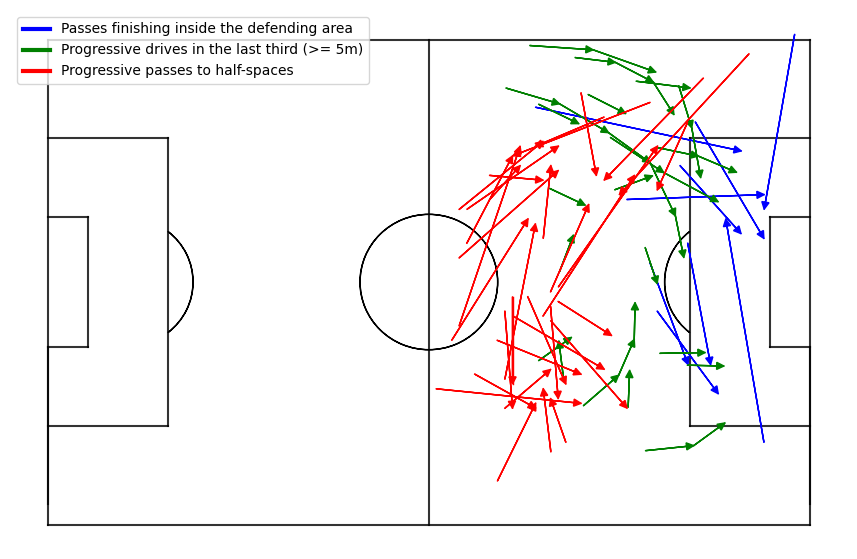

In [30]:
def plot_features_on_field(df, match_id, fig_size=7, width=105, height=68):
    fig, ax = _draw_field(fig_size=fig_size, width=width, height=height, lines_color='black')

    passes_in_defending_area = filter_passes_to_defending_area(df, match_id)
    progressive_drives = filter_progressive_drives(df, match_id)
    progressive_passes = filter_progressive_passes_to_half_spaces(df, match_id)

    for _, row in passes_in_defending_area.iterrows():
        ax.plot([row['norm_origin_pos_x'] * width, row['norm_destination_pos_x'] * width],
                [row['norm_origin_pos_y'] * height, row['norm_destination_pos_y'] * height],
                color='blue', linewidth=1, zorder=5)
        dx = row['norm_destination_pos_x'] * width - row['norm_origin_pos_x'] * width
        dy = row['norm_destination_pos_y'] * height - row['norm_origin_pos_y'] * height
        ax.arrow(row['norm_origin_pos_x'] * width, row['norm_origin_pos_y'] * height,
                 dx, dy, head_width=1, head_length=1, fc='blue', ec='blue', zorder=10, length_includes_head=True)

    for _, row in progressive_drives.iterrows():
        ax.plot([row['norm_origin_pos_x'] * width, row['norm_destination_pos_x'] * width],
                [row['norm_origin_pos_y'] * height, row['norm_destination_pos_y'] * height],
                color='green', linewidth=1, zorder=5)
        dx = row['norm_destination_pos_x'] * width - row['norm_origin_pos_x'] * width
        dy = row['norm_destination_pos_y'] * height - row['norm_origin_pos_y'] * height
        ax.arrow(row['norm_origin_pos_x'] * width, row['norm_origin_pos_y'] * height,
                 dx, dy, head_width=1, head_length=1, fc='green', ec='green', zorder=10, length_includes_head=True)

    for _, row in progressive_passes.iterrows():
        ax.plot([row['norm_origin_pos_x'] * width, row['norm_destination_pos_x'] * width],
                [row['norm_origin_pos_y'] * height, row['norm_destination_pos_y'] * height],
                color='red', linewidth=1, zorder=5)
        dx = row['norm_destination_pos_x'] * width - row['norm_origin_pos_x'] * width
        dy = row['norm_destination_pos_y'] * height - row['norm_origin_pos_y'] * height
        ax.arrow(row['norm_origin_pos_x'] * width, row['norm_origin_pos_y'] * height,
                 dx, dy, head_width=1, head_length=1, fc='red', ec='red', zorder=10, length_includes_head=True)

    blue_patch = plt.Line2D([0], [0], color='blue', lw=3, label='Passes finishing inside the defending area')
    green_patch = plt.Line2D([0], [0], color='green', lw=3, label='Progressive drives in the last third (>= 5m)')
    red_patch = plt.Line2D([0], [0], color='red', lw=3, label='Progressive passes to half-spaces')
    ax.legend(handles=[blue_patch, green_patch, red_patch], loc='upper left')

    plt.show()

match_id = df_successful_2ndhalf['match_id'].unique()[0]
plot_features_on_field(df_successful_2ndhalf, match_id)
